In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "4"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

fish-gcp005
/home/akarshkumar0101/nca-alife/src
/home/akarshkumar0101/miniconda3/envs/nca-alife-torch/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import experiment_utils
import util

# Create Experiment

In [4]:
! rm -rf ./experiments
! mkdir -p ./experiments

In [185]:
cfg_default = dict(
    seed=0, save_dir=None, dtype='float32', device='cuda:0',
    
    img_size=64, d_state=16, perception='fullconv', kernel_size=3, # changed img_size
    init_state="point", padding_mode="circular", dt=0.01, dropout=0.0, # changed dropout and initial state
    
    prompts="a circle;a square", spatial_scales="0.015625;1.0", clip_model="clip-vit-base-patch32",
    coef_alignment=1., coef_spatial_softmax=0.,
    
    rollout_steps=128, bptt_steps=16, pool_size=128, # changed the rollout steps and the pool size
    bs=8, lr=3e-4, n_iters=100000, clip_grad_norm=1.
)

seeds = np.arange(1)

prompts_sweep = ["a very fat cat", "a biological cell", "bacteria under the microscope", "particles in a gas",
                 "a lizard", "an ecosystem of life", "a random thing",
                 "a green circle", "a red square", "a blue triangle",]
spatial_scales_sweep = ["0.01", "0.033", "0.1", "0.33", "1."]


# coef_spatial_softmax_sweep = [0., 1e-2, 3e-2, 1e-1]
# coef_spatial_softmax_sweep = [0.]+np.logspace(-3, 0, num=15).tolist()

cfgs = []
for seed in seeds:
    for i1, prompts in enumerate(prompts_sweep):
        for i2, spatial_scales in enumerate(spatial_scales_sweep):
            cfg = cfg_default.copy()
            cfg.update(seed=seed, prompts=prompts, spatial_scales=spatial_scales)
            cfg.update(save_dir=f"/home/akarshkumar0101/nca-alife-data/nca_scale3/{seed}_{prompts}_{spatial_scales}")
            cfgs.append(cfg)

# print(cfgs)
print(len(cfgs))

50


In [186]:
commands = experiment_utils.create_commands(cfgs, prefix='python train_nca_temporal_emergence.py', out_file='./experiments/main.sh')
print('\n'.join(commands[:3]), '\n...')
print(len(commands), 'commands')

python train_nca_temporal_emergence.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/nca_scale3/0_a very fat cat_0.01"                 --dtype="float32" --device="cuda:0" --img_size=64 --d_state=16 --perception="fullconv" --kernel_size=3 --init_state="point" --padding_mode="circular" --dt=0.01 --dropout=0.0 --prompts="a very fat cat"                --spatial_scales="0.01"  --clip_model="clip-vit-base-patch32" --coef_alignment=1.0 --coef_spatial_softmax=0.0 --rollout_steps=128 --bptt_steps=16 --pool_size=128 --bs=8 --lr=0.0003 --n_iters=100000 --clip_grad_norm=1.0
python train_nca_temporal_emergence.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/nca_scale3/0_a very fat cat_0.033"                --dtype="float32" --device="cuda:0" --img_size=64 --d_state=16 --perception="fullconv" --kernel_size=3 --init_state="point" --padding_mode="circular" --dt=0.01 --dropout=0.0 --prompts="a very fat cat"                --spatial_scales="0.033" --clip_model="clip-vit-base-pa

# Visualize Results

In [299]:
import torch
from torchvision import transforms
from torchvision.transforms import InterpolationMode

In [190]:
spatial_scales = [float(s) for s in cfg['spatial_scales'].split(';')]
crop_img_scales = [transforms.RandomResizedCrop(224, scale=(s, s), interpolation=InterpolationMode.NEAREST, ratio=(3./4., 4./3.)) for s in spatial_scales]
# crop_img_scales = [transforms.RandomResizedCrop(224, scale=(s, s), interpolation=InterpolationMode.BILINEAR, ratio=(3./4., 4./3.)) for s in spatial_scales]
augment_img = transforms.Compose([
    # transforms.RandomRotation()
    # transforms.RandomPerspective(distortion_scale=0.5, p=1., fill=0.),
])

img_cropped = torch.stack([augment_img(crop_img(torch.from_numpy(rearrange(img, "B H W D -> B D H W")))) for crop_img in crop_img_scales])

img_cropped = rearrange(img_cropped.cpu().numpy(), "... D H W -> ... H W D")

In [192]:
spatial_scales_sweep

['0.01', '0.033', '0.1', '0.33', '1.']

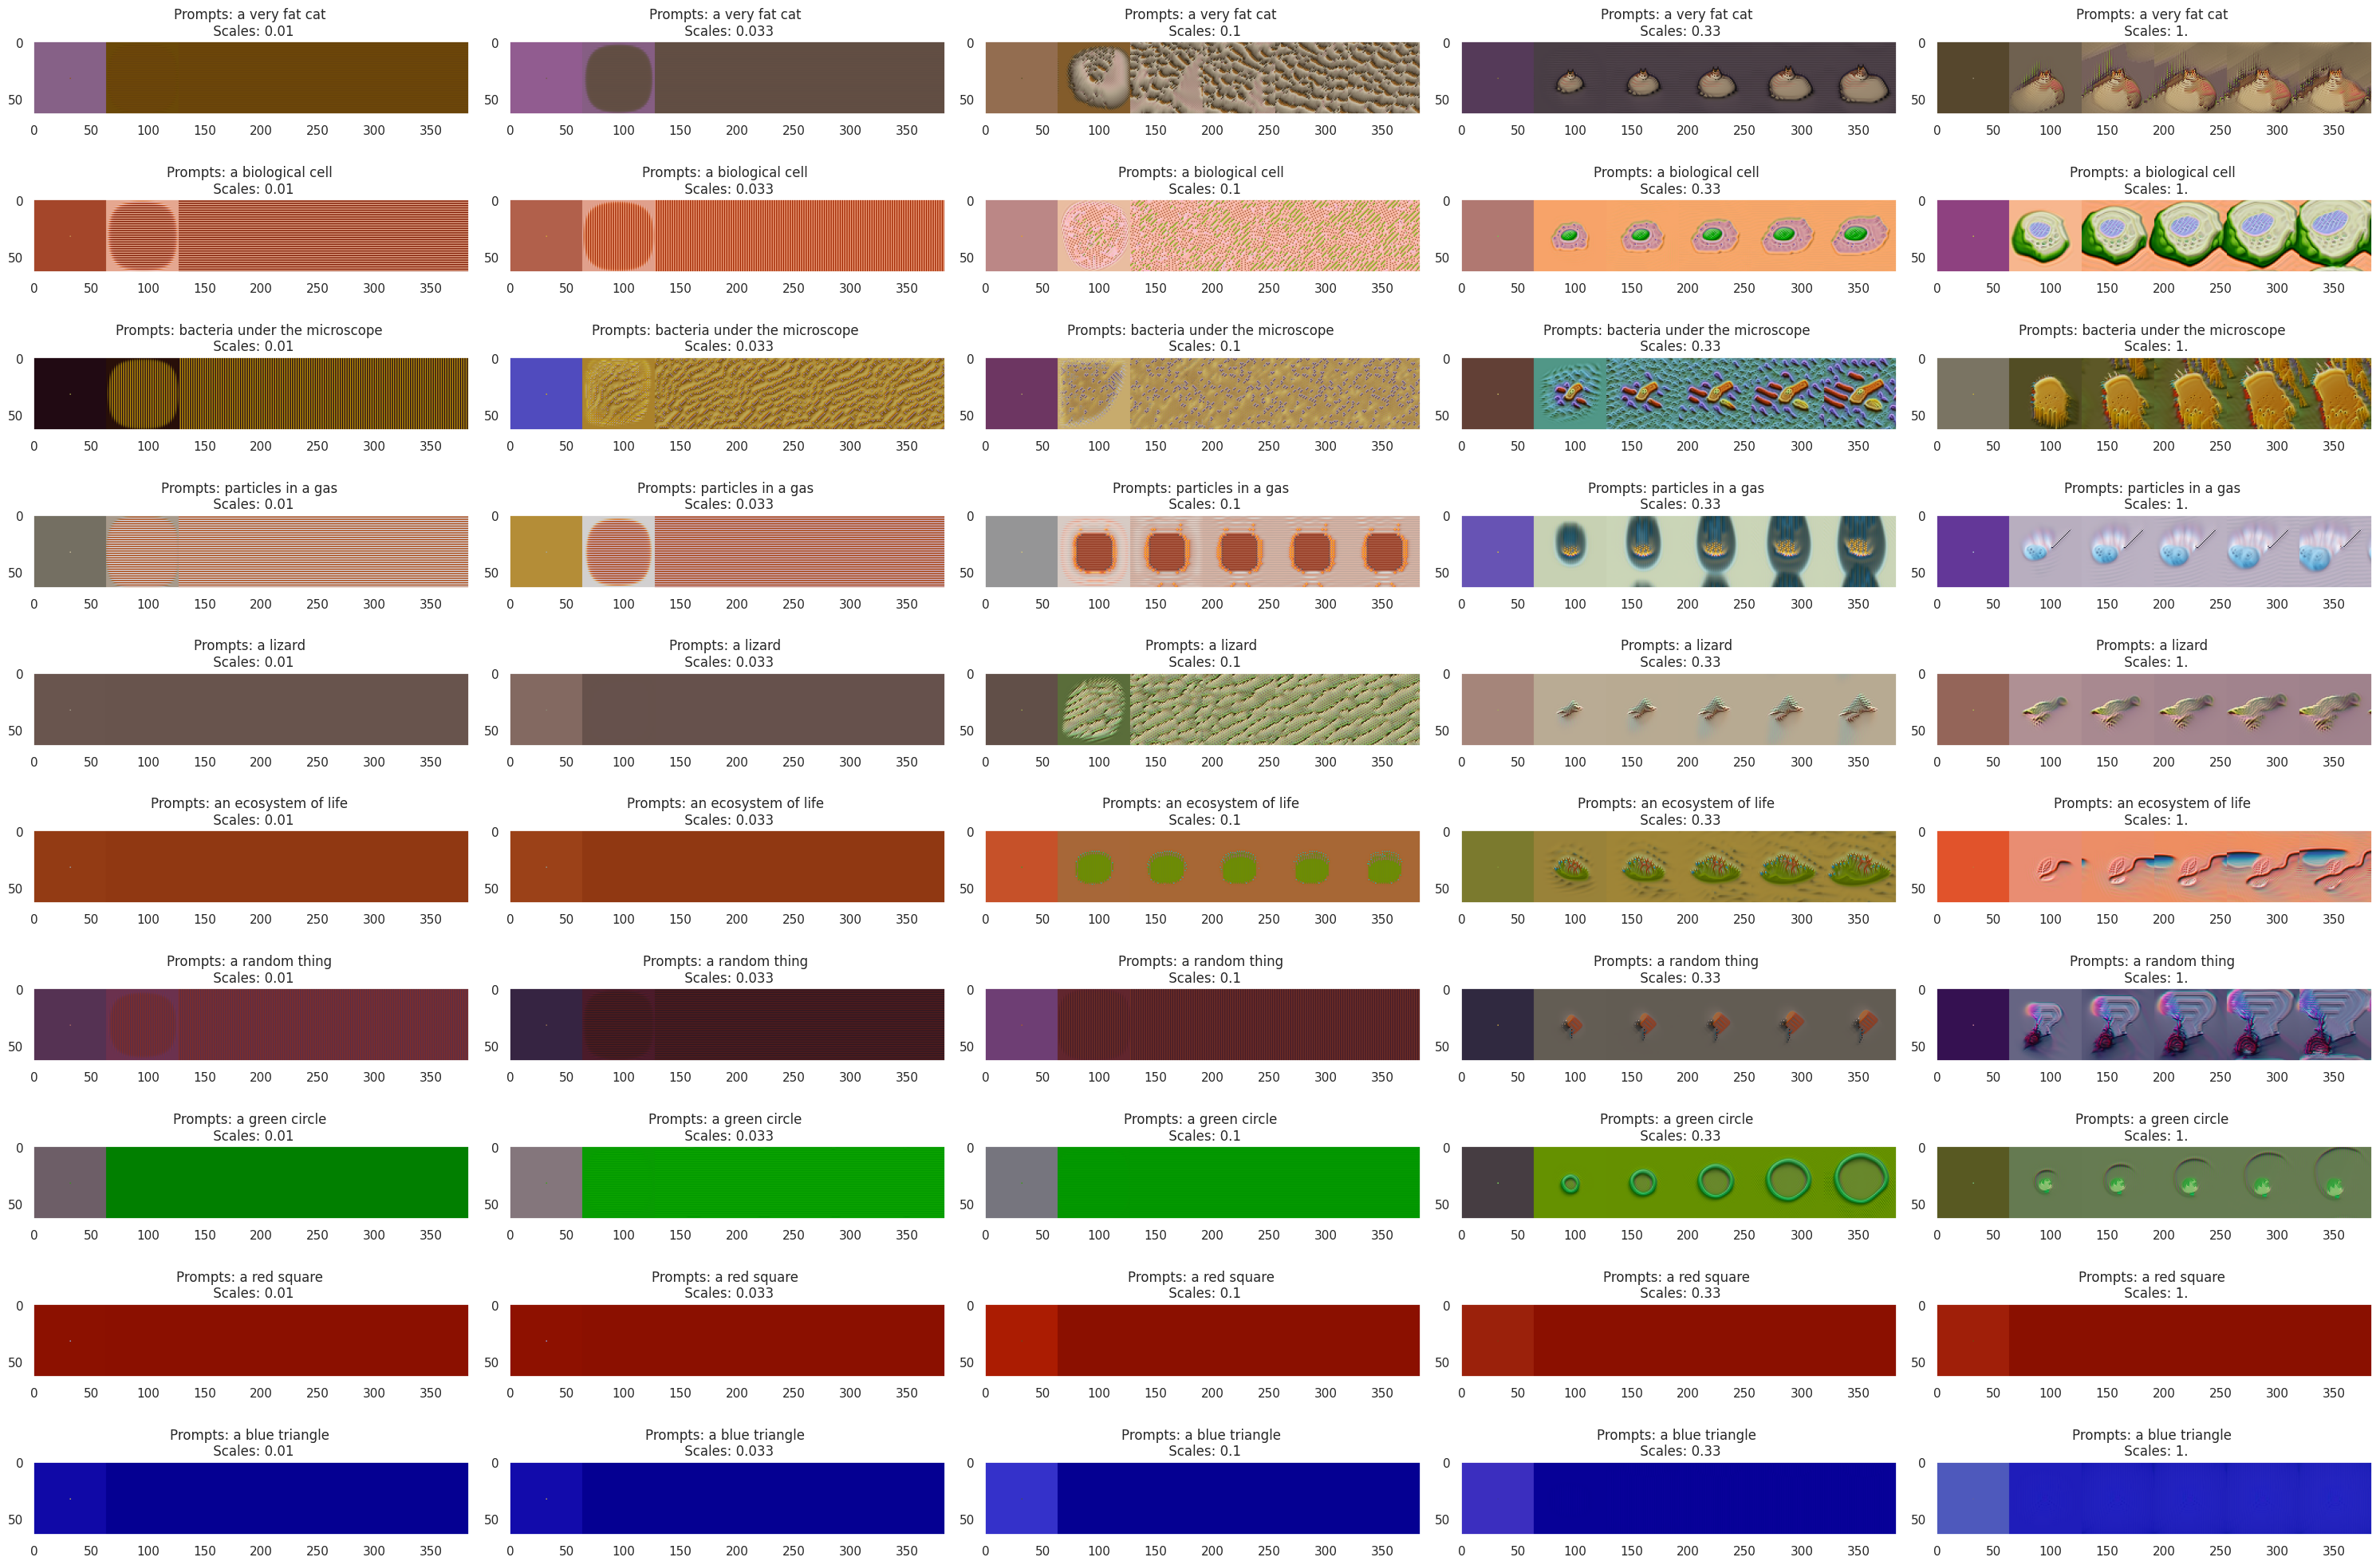

In [300]:
plt.figure(figsize=(30, 20))
iplt = 0

for cfg in cfgs:
    save_dir = cfg['save_dir']
    vid = util.load_pkl(save_dir, 'vid').astype(np.uint8)
    img = vid[[0, 32, 64, 96, 128, 160]]

    # img_cropped = torch.stack([augment_img(crop_img(torch.from_numpy(rearrange(img, "B H W D -> B D H W")))) for crop_img in crop_img_scales])
    # img_cropped = rearrange(img_cropped.cpu().numpy(), "... D H W -> ... H W D")

    iplt += 1
    plt.subplot(10, 5, iplt)
    plt.imshow(rearrange(img, "C H W D -> H (C W) D"))
    # plt.imshow(rearrange(img_cropped, "R C H W D -> (R H) (C W) D"))
    plt.grid(False)

    plt.title(f"Prompts: {cfg['prompts']} \n Scales: {cfg['spatial_scales']}")

plt.tight_layout()
plt.show()
    

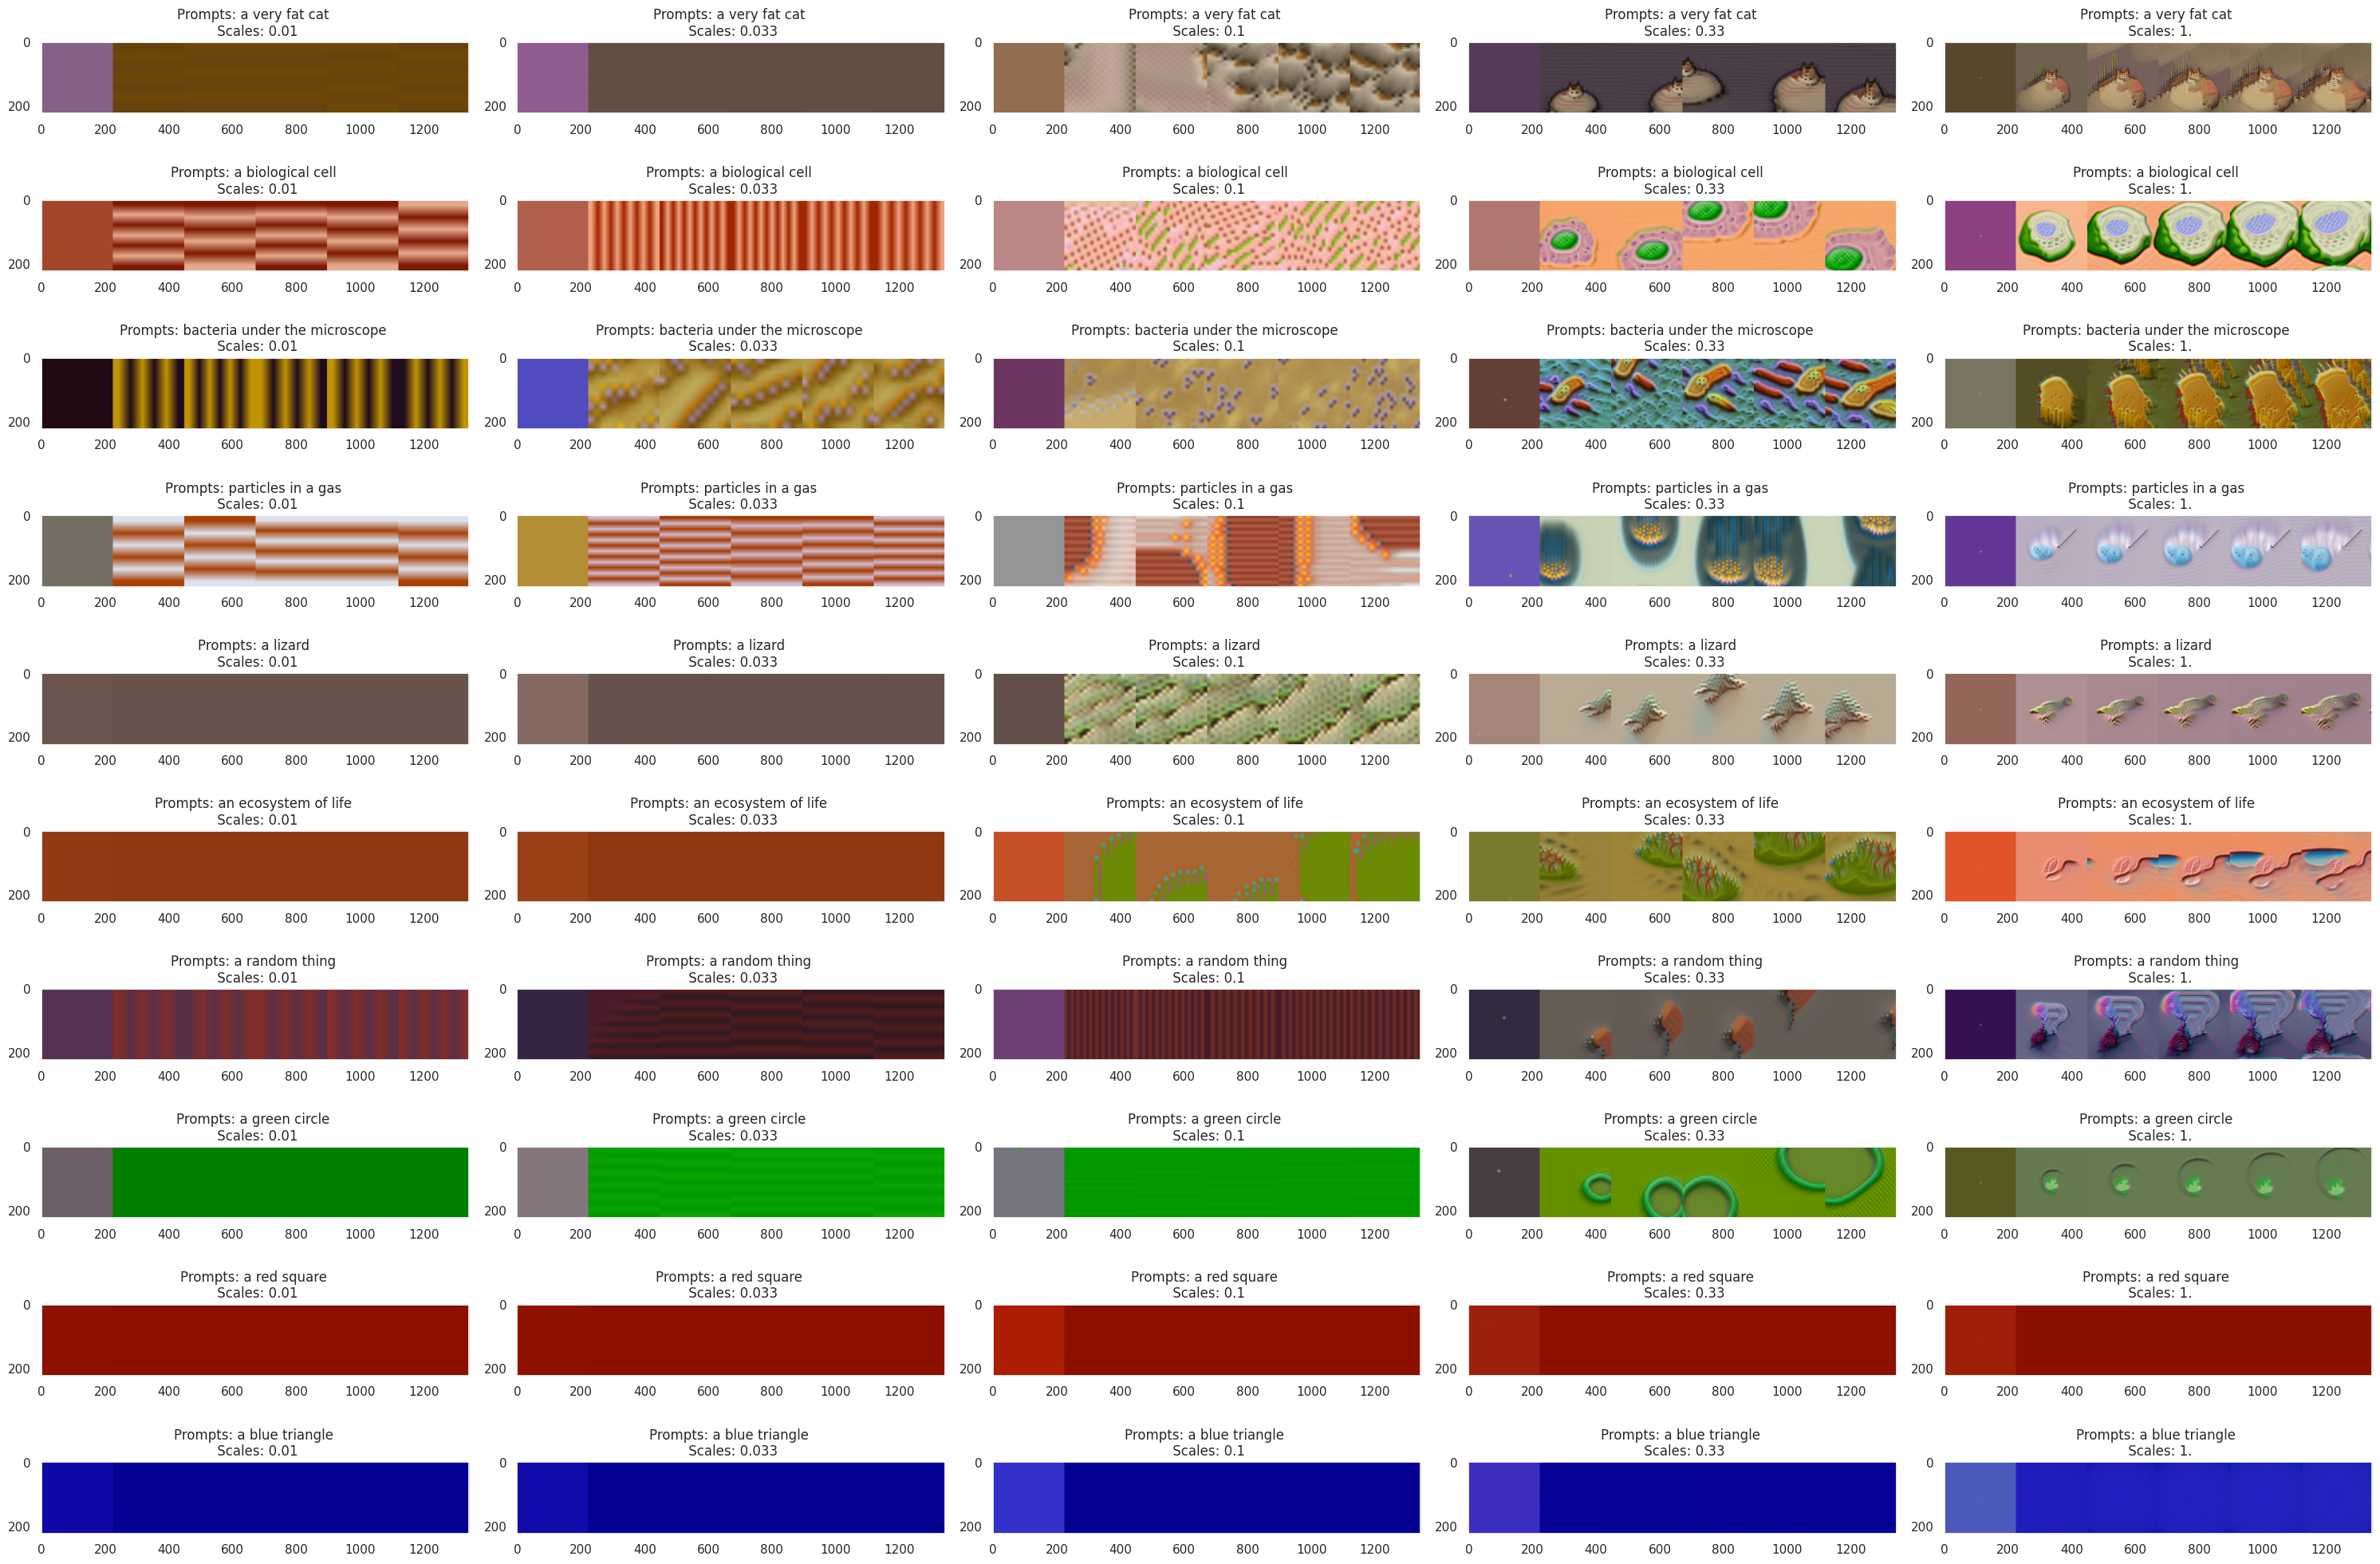

In [301]:
plt.figure(figsize=(30, 20))
iplt = 0

for cfg in cfgs:
    save_dir = cfg['save_dir']
    vid = util.load_pkl(save_dir, 'vid').astype(np.uint8)
    img = vid[[0, 32, 64, 96, 128, 160]]
    
    s = float(cfg['spatial_scales'])
    aug = transforms.RandomResizedCrop(224, scale=(s, s), interpolation=InterpolationMode.BILINEAR, ratio=(3./4., 4./3.))

    # print(img.shape)
    img = rearrange(torch.from_numpy(img), "B H W D -> B D H W")
    img = [aug(i) for i in img]
    # img = aug(img)
    img = rearrange(img, "B D H W -> B H W D").numpy()
    # print(img.shape)
    # print()

    iplt += 1
    plt.subplot(10, 5, iplt)
    plt.imshow(rearrange(img, "C H W D -> H (C W) D"))
    # plt.imshow(rearrange(img_cropped, "R C H W D -> (R H) (C W) D"))
    plt.grid(False)

    plt.title(f"Prompts: {cfg['prompts']} \n Scales: {cfg['spatial_scales']}")

plt.tight_layout()
plt.show()
    

In [302]:
import copy
df = []
for cfg in cfgs:
    save_dir = cfg['save_dir']
    data = util.load_pkl(save_dir, 'data')
    
    dfi = copy.copy(cfg)

    for k, v in data.items():
        if v.ndim==1:
            dfi[f"{k}"] = v[-100:].mean()
            dfi[f"{k}_init"] = v[:100].mean()
    df.append(dfi)
df = pd.DataFrame(df)

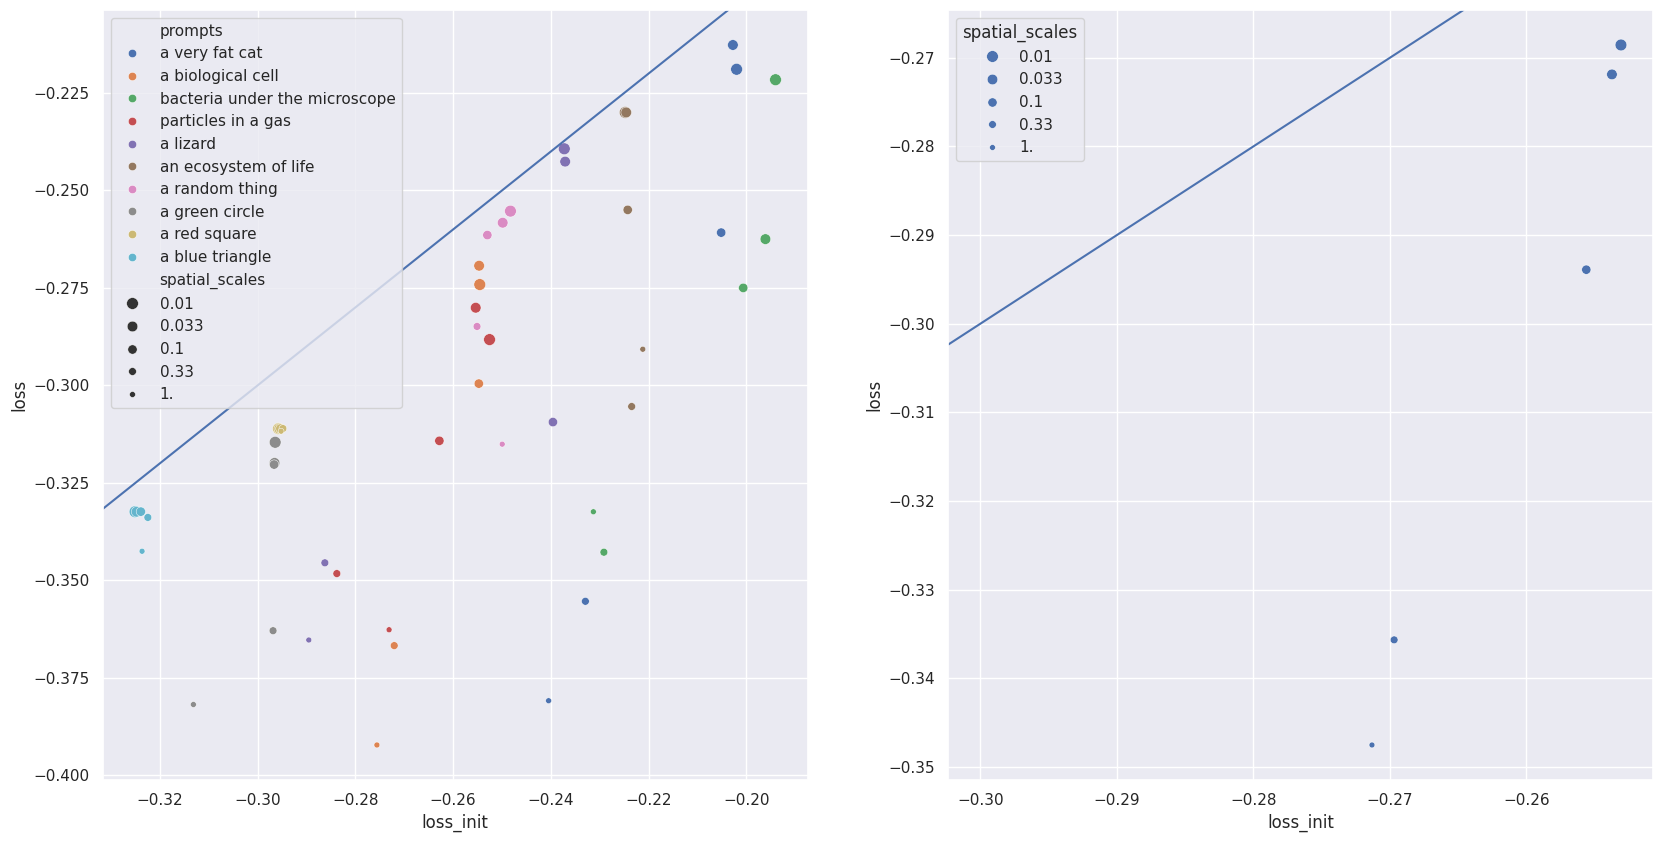

In [303]:
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.scatterplot(data=df, x='loss_init', y='loss', hue='prompts', size='spatial_scales')
plt.gca().axline((-.3, -.3), slope=1)
plt.subplot(122)
sns.scatterplot(data=df[["spatial_scales", "loss", "loss_init"]].groupby("spatial_scales").mean(), x='loss_init', y='loss', size='spatial_scales')
plt.gca().axline((-.3, -.3), slope=1)

<Axes: xlabel='spatial_scales', ylabel='loss'>

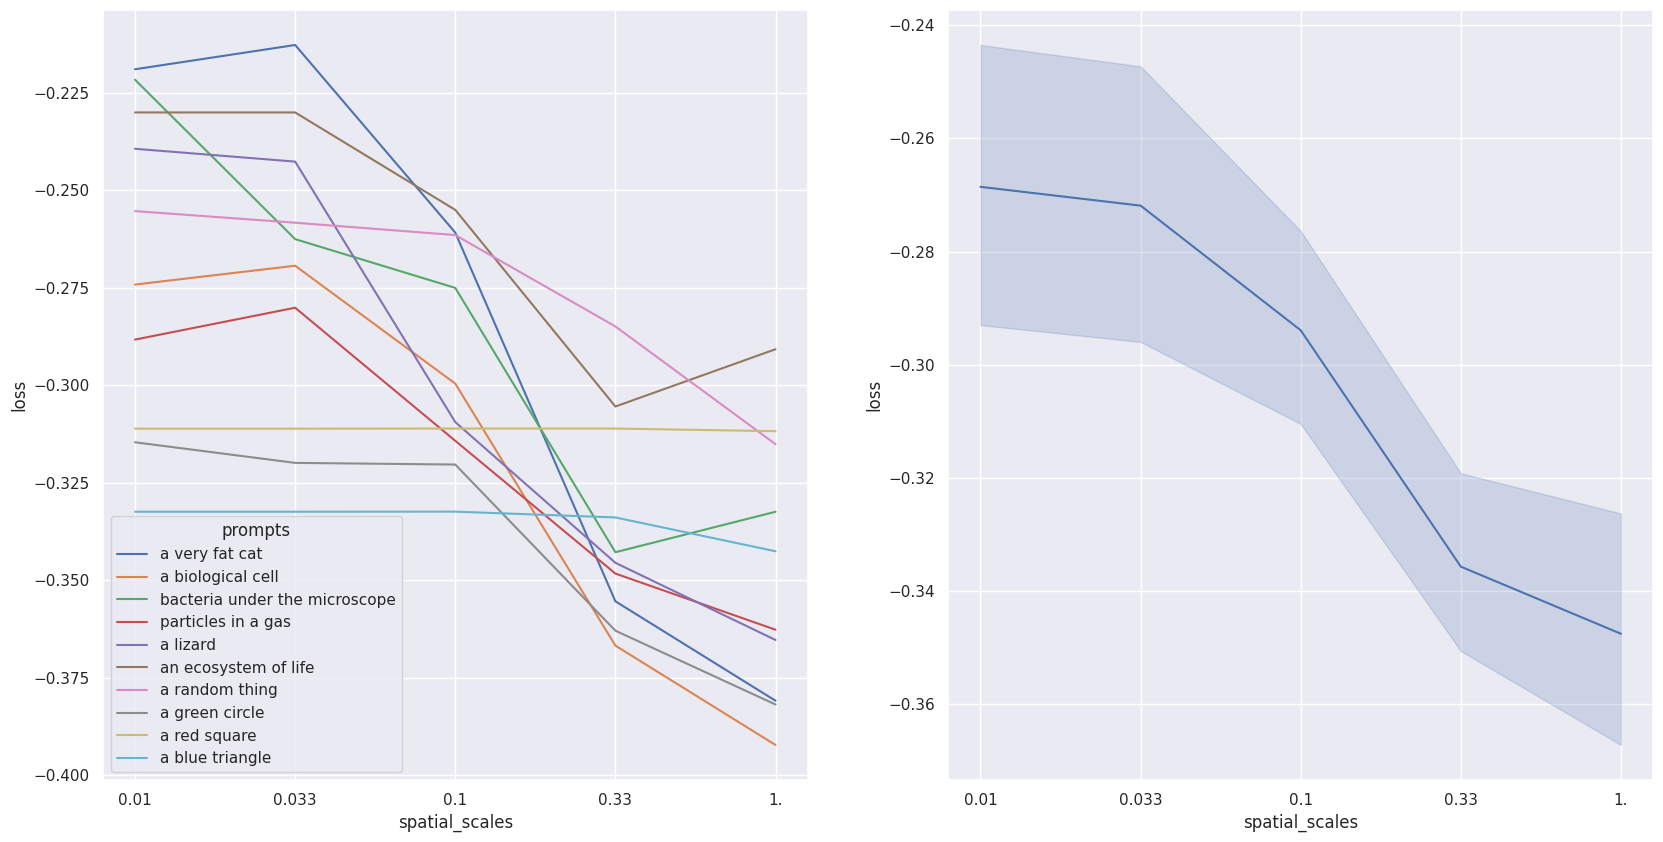

In [304]:
plt.figure(figsize=(20, 10))
plt.subplot(121)
sns.lineplot(data=df, x='spatial_scales', y='loss', hue='prompts')
plt.subplot(122)
sns.lineplot(data=df, x='spatial_scales', y='loss')